<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">TABLE OF CONTENTS</p>

* [1. IMPORTING LIBRARIES](#1)
* [2. LOADING DATA](#2)    
* [3. DATA PIPELINE](#3) (Maleable section)
* [4. EXPLORATORY DATA ANALYSIS](#4)     
* [5. MODELING](#5)
* [6. EVALUATION](#6)
* [7. DISCUSSION](#7)  
* [8. DEPLOYMENT AND ENSEMBLES](#8)
* [9. END](#9)

<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">IMPORTING LIBRARIES</p>

In [1]:
# Parameters
path_root = "/home/magody/programming/python/data_science/"
path_output = f"{path_root}output/"

In [133]:
import os
import sys
sys.path.append(f"{path_root}lib")

from MongoDatabase import MongoDatabase  # type: ignore
from utils_pandas import getDeepKeyValues  # type: ignore
from stats import correlation_heatmap  # type: ignore
from insight import exploreSurface, describeDataset, getMissingAndDuplicates, categorizeColumns  # type: ignore
from evaluation import evaluateClassificationNeuralNetwork  # type: ignore



In [120]:

import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import tree
from sklearn import naive_bayes
from sklearn import gaussian_process
from sklearn import discriminant_analysis
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from xgboost import XGBClassifier
    
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

# Hypertunning libraries
import keras_tuner as kt
from sklearn.model_selection import StratifiedKFold, KFold

2022-05-13 11:06:25.486754: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-13 11:06:25.486791: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<a id="2"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">LOADING DATA</p>

## Description

TODO: Set a visuals about the data

## Load

* \$ docker run -p 27040:27017 -v /home/magody/programming/python/data_science/containers_data/mongodb:/data/db --name mongodb_datascience -it mongo
* OR
* \$ docker start mongodb_datascience

In [7]:
# MOCK
os.environ["MODE"] = "development"
os.environ["MONGODB_USER"] = "developer"
os.environ["MONGODB_PASS"] = "developer123"
os.environ["MONGODB_HOST"] = "localhost"
os.environ["MONGODB_PORT"] = "27040"
os.environ["MONGODB_DATABASE"] = "apifootball"

In [29]:
class PipelineLoad:
    """Reusable pipeline to manage data loading and initial preparation
    """
    
    def __init__(self, mongoDB:MongoDatabase):
        self.mongoDB = mongoDB
        
    def getDataFrameTeamStatistics(self, filter:dict, reduced_df=False)->pd.DataFrame:
        
        team_statistics = self.mongoDB.find_all("team_statistics", filter)
        print(f"Teams: {len(team_statistics)}")
        
        column_data:dict = dict()
        len_team_statistics = len(team_statistics)
        
        for team in team_statistics:
            getDeepKeyValues(team, "", column_data)
        
        pending_delete_outliers = []
        for k, column in column_data.items():
            if len(column) != len_team_statistics:
                pending_delete_outliers.append(k)
                print("Outlier, probably out of 120min time: ", k, len(column))
                
        for po in pending_delete_outliers:
            del column_data[po]
            
        df_teams_statistics = pd.DataFrame.from_dict(column_data)
        df_teams_statistics.replace({np.nan: int(0), None:int(0)}, inplace=True)
        
        if reduced_df:
            columns_reduced = ["team_id", "team_name", "league_id", "season_id", "fixtures_summary_played_home", "fixtures_summary_played_away", "fixtures_summary_wins_home", "fixtures_summary_wins_away", "fixtures_summary_draws_home", "fixtures_summary_draws_away", "fixtures_summary_loses_home", "fixtures_summary_loses_away", "goals_summary_for_total_home", "goals_summary_for_total_away", "goals_summary_for_average_home", "goals_summary_for_average_away", "goals_summary_against_total_home", "goals_summary_against_total_away", "goals_summary_against_average_home", "goals_summary_against_average_away", "penalty_scored_total", "penalty_scored_percentage", "penalty_missed_total", "penalty_missed_percentage", "penalty_total", "cards_yellow", "cards_red"]
            df_teams_statistics = df_teams_statistics.loc[:,columns_reduced[:-2]]
            df_teams_statistics["cards_yellow"] = 0
            df_teams_statistics["cards_red"] = 0

            for c in df_teams_statistics.columns.values:
                # aggregating results in specific columns
                if "cards_yellow" in c and "total" in c:
                    df_teams_statistics["cards_yellow"] += df_teams_statistics[c]
                elif "cards_red" in c and "total" in c:
                    df_teams_statistics["cards_red"] += df_teams_statistics[c]

        df_teams_statistics.rename(columns={
            "team_id": "team",
            "team_name": "name",
            "league_id": "league",
            "season_id": "season",
            "fixtures_summary_played_home": "home_played",
            "fixtures_summary_played_away": "away_played",
            "fixtures_summary_wins_home": "home_wins",
            "fixtures_summary_wins_away": "away_wins",
            "fixtures_summary_draws_home": "home_draws",
            "fixtures_summary_draws_away": "away_draws",
            "fixtures_summary_loses_home": "home_loses",
            "fixtures_summary_loses_away": "away_loses",
            "goals_summary_for_total_home": "home_goals_for",
            "goals_summary_for_total_away": "away_goals_for",
            "goals_summary_for_average_home": "home_goals_for_average",
            "goals_summary_for_average_away": "away_goals_for_average",
            "goals_summary_against_total_home": "home_goals_against",
            "goals_summary_against_total_away": "away_goals_against",
            "goals_summary_against_average_home": "home_goals_against_average",
            "goals_summary_against_average_away": "away_goals_against_average",
            "penalty_scored_total": "penalty_scored_total",
            "penalty_scored_percentage": "penalty_scored_percentage",
            "penalty_missed_total": "penalty_missed_total",
            "penalty_missed_percentage": "penalty_missed_percentage",
            "penalty_total": "penalty_total",
        }, inplace=True)
        return df_teams_statistics
    
    def getDataFrameFixtures(self, filter:dict)->pd.DataFrame:
        
        fixtures = mongoDB.find_all("fixtures", filter)
        column_data:dict = dict()
        len_fixtures = len(fixtures)
        for fixture in fixtures:
            getDeepKeyValues(fixture, "", column_data)
            
        pending_delete_outliers = []
        for k, column in column_data.items():    
            if len(column) != len_fixtures:
                pending_delete_outliers.append(k)
                print("Outlier, probably out of 120min time: ", k, len(column))
                
        for po in pending_delete_outliers:
            del column_data[po]

        df_fixtures = pd.DataFrame.from_dict(column_data)
        df_fixtures.replace({np.nan: int(0), None:int(0)}, inplace=True)
        return df_fixtures
        
        
ENV_MONGODB_USER = os.environ.get("MONGODB_USER")
ENV_MONGODB_PASS = os.environ.get("MONGODB_PASS")
ENV_MONGODB_HOST = os.environ.get("MONGODB_HOST")
ENV_MONGODB_PORT = os.environ.get("MONGODB_PORT")
ENV_MONGODB_DATABASE = os.environ.get("MONGODB_DATABASE")
mongoDB = MongoDatabase(ENV_MONGODB_DATABASE, f"mongodb://{ENV_MONGODB_USER}:{ENV_MONGODB_PASS}@{ENV_MONGODB_HOST}:{ENV_MONGODB_PORT}/{ENV_MONGODB_DATABASE}?retryWrites=true&w=majority")

pipelineLoad = PipelineLoad(mongoDB)
season:int = 2022
league:int = 34
filter_season_league = {"season_id": season, "league_id": league}

df_teams_statistics = pipelineLoad.getDataFrameTeamStatistics(filter_season_league, reduced_df=True)
df_fixtures = pipelineLoad.getDataFrameFixtures(filter_season_league)

Teams: 10
Outlier, probably out of 120min time:  cards_yellow__total 4
Outlier, probably out of 120min time:  cards_yellow__percentage 4
Outlier, probably out of 120min time:  cards_red__total 1
Outlier, probably out of 120min time:  cards_red__percentage 1


In [30]:
df_teams_statistics.head()

,team,name,league,season,home_played,away_played,home_wins,away_wins,home_draws,away_draws,...,away_goals_against,home_goals_against_average,away_goals_against_average,penalty_scored_total,penalty_scored_percentage,penalty_missed_total,penalty_missed_percentage,penalty_total,cards_yellow,cards_red
0,2383,Chile,34,2022,9,9,3,2,2,2,...,16,1.1,1.8,1,100.00%,0,0%,1,0,0
1,7,Uruguay,34,2022,9,9,5,3,2,2,...,15,0.8,1.7,6,100.00%,0,0%,6,0,0
2,6,Brazil,34,2022,8,9,8,6,0,3,...,4,0.1,0.4,6,100.00%,0,0%,6,0,0
3,8,Colombia,34,2022,9,9,3,2,4,4,...,12,0.8,1.3,5,100.00%,0,0%,5,0,0
4,2381,Bolivia,34,2022,9,9,4,0,1,2,...,28,1.6,3.1,2,100.00%,0,0%,2,0,0


In [23]:
df_fixtures.head()

,_id,id,team_home_id,team_home_name,team_home_logo,team_home_winner,team_away_id,team_away_name,team_away_logo,team_away_winner,...,home_lineups_substitutes,away_lineups_coach_id,away_lineups_coach_name,away_lineups_coach_photo,away_lineups_formation,away_lineups_startXI,away_lineups_substitutes,home_statistics_players,away_statistics_players,events
0,627e616734b32912e4379b7e,293576,7,Uruguay,https://media.api-sports.io/football/teams/7.png,True,2383,Chile,https://media.api-sports.io/football/teams/238...,False,...,"[{'player': {'id': 2614, 'name': 'N. Nández', ...",332,R. Rueda,https://media.api-sports.io/football/coachs/33...,4-4-2,"[{'player': {'id': 2547, 'name': 'G. Arias', '...","[{'player': {'id': 11368, 'name': 'C. Pinares'...","[{'player': {'id': 2608, 'name': 'Martín Campa...","[{'player': {'id': 2547, 'name': 'Gabriel Aria...","[{'time': {'elapsed': 36, 'extra': None}, 'tea..."
1,627e616734b32912e4379b7f,293577,8,Colombia,https://media.api-sports.io/football/teams/8.png,True,2379,Venezuela,https://media.api-sports.io/football/teams/237...,False,...,"[{'player': {'id': 35539, 'name': 'S. Medina',...",3107,José Peseiro,https://media.api-sports.io/football/coachs/31...,4-2-3-1,"[{'player': {'id': 2437, 'name': 'W. Fariñez',...","[{'player': {'id': 53748, 'name': 'A. Ponce', ...","[{'player': {'id': 2482, 'name': 'Camilo Varga...","[{'player': {'id': 2437, 'name': 'Wuilker Farí...","[{'time': {'elapsed': 4, 'extra': None}, 'team..."
2,627e616734b32912e4379b80,293578,6,Brazil,https://media.api-sports.io/football/teams/6.png,True,2381,Bolivia,https://media.api-sports.io/football/teams/238...,False,...,"[{'player': {'id': 10009, 'name': 'Rodrygo', '...",392,C. Farías,https://media.api-sports.io/football/coachs/39...,4-5-1,"[{'player': {'id': 2388, 'name': 'C. Lampe', '...","[{'player': {'id': 48608, 'name': 'B. Cespedes...","[{'player': {'id': 2410, 'name': 'Weverton', '...","[{'player': {'id': 2388, 'name': 'Carlos Lampe...","[{'time': {'elapsed': 16, 'extra': None}, 'tea..."
3,627e616834b32912e4379b81,293579,2380,Paraguay,https://media.api-sports.io/football/teams/238...,0,30,Peru,https://media.api-sports.io/football/teams/30.png,0,...,"[{'player': {'id': 70473, 'name': 'R. Sánchez'...",328,R. Gareca,https://media.api-sports.io/football/coachs/32...,4-1-4-1,"[{'player': {'id': 2417, 'name': 'P. Gallese',...","[{'player': {'id': 478, 'name': 'J. Farfán', '...","[{'player': {'id': 2497, 'name': 'Gatito Ferná...","[{'player': {'id': 2417, 'name': 'Pedro Galles...","[{'time': {'elapsed': 18, 'extra': None}, 'tea..."
4,627e616834b32912e4379b82,293580,26,Argentina,https://media.api-sports.io/football/teams/26.png,True,2382,Ecuador,https://media.api-sports.io/football/teams/238...,False,...,"[{'player': {'id': 576, 'name': 'E. Salvio', '...",861,G. Alfaro,https://media.api-sports.io/football/coachs/86...,4-1-4-1,"[{'player': {'id': 2568, 'name': 'A. Domínguez...","[{'player': {'id': 2583, 'name': 'A. Preciado'...","[{'player': {'id': 2463, 'name': 'Franco Arman...","[{'player': {'id': 2568, 'name': 'Alexander Do...","[{'time': {'elapsed': 13, 'extra': None}, 'tea..."


## Eager explotarion

In [25]:
df_teams_statistics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Columns: 117 entries, _id to cards_red_106-120_percentage
dtypes: float64(15), int64(58), object(44)
memory usage: 9.3+ KB


In [26]:
df_fixtures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   _id                       28 non-null     object 
 1   id                        28 non-null     int64  
 2   team_home_id              28 non-null     int64  
 3   team_home_name            28 non-null     object 
 4   team_home_logo            28 non-null     object 
 5   team_home_winner          28 non-null     object 
 6   team_away_id              28 non-null     int64  
 7   team_away_name            28 non-null     object 
 8   team_away_logo            28 non-null     object 
 9   team_away_winner          28 non-null     object 
 10  league_id                 28 non-null     int64  
 11  season_id                 28 non-null     int64  
 12  referee                   28 non-null     object 
 13  venue_id                  28 non-null     float64
 14  timezone    

<a id="3"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">DATA PIPELINE</p>
- Special section: is used before and after by the following sections.
- Atemporal: This means that after perform EDA or modeling we can come back here and improve the pipeline. Maleable section.
- Here we define a pipeline for cleaning, preprocessing, dimensionality reduction, feature enginering, etc.
- Commonly, we use the insights got in EDA for write this part.

In [45]:
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

class PipelineDataProcessing:
    
    def __init__(self, columns_categories:dict = {}, dimension_reduction_to=3) -> None:
        self.mask_importances = []
        self.columns_categories = columns_categories
        self.dimension_reduction_to = dimension_reduction_to
        self.cache = dict()

    def processMissing(self, X_raw:pd.DataFrame, y=None):
        return X_raw, y

    def processDuplicates(self, X_raw:pd.DataFrame, y=None):
        return X_raw, y

    def featureEngineering(self, X_raw:pd.DataFrame, y=None):
        avg_num_goals_scored_home = X_raw['home_goals_for'].sum()/X_raw['home_played'].sum()
        avg_num_goals_scored_away = X_raw['away_goals_for'].sum()/X_raw['away_played'].sum()
        avg_num_goals_conc_home = avg_num_goals_scored_away
        avg_num_goals_conc_away = avg_num_goals_scored_home
        
        self.cache["feature_engineering"] = {
            "avg_num_goals_scored_home": avg_num_goals_scored_home,
            "avg_num_goals_scored_away": avg_num_goals_scored_away,
            "avg_num_goals_conc_home": avg_num_goals_conc_home,
            "avg_num_goals_conc_away": avg_num_goals_conc_away,
        }

        X_raw["strenght_attack_home"] = X_raw['home_goals_for'] / X_raw['home_played'] / avg_num_goals_scored_home
        X_raw["strenght_attack_away"] = X_raw['away_goals_for'] / X_raw['away_played'] / avg_num_goals_scored_away
        X_raw["strenght_defense_home"] = X_raw['home_goals_against'] / X_raw['home_played'] / avg_num_goals_conc_home
        X_raw["strenght_defense_away"] = X_raw['away_goals_against'] / X_raw['away_played'] / avg_num_goals_conc_away

        return X_raw, y

    def processCategorical(self, X_raw:pd.DataFrame, y=None):
        return X_raw, y

    def processOutliers(self, X_raw:pd.DataFrame, y=None):
        return X_raw, y

    def scaleData(self, X_raw:pd.DataFrame, y=None):
        return X_raw, y


    def reduceDimension(self, X_raw:pd.DataFrame, y=None):
        return X_raw, y

    def processFinal(self, X_raw:pd.DataFrame, y=None):
        return X_raw, y
        
    def transform(self, X_raw:pd.DataFrame, y=None, is_training=True):
        
        X_clean = X_raw.copy()

        if y is not None:
            y_clean = y.copy()
        else:
            y_clean = None

        X_clean, y_clean = self.processMissing(X_clean, y_clean)
        X_clean, y_clean = self.processDuplicates(X_clean, y_clean)
        X_clean, y_clean = self.featureEngineering(X_clean, y_clean)
        X_clean, y_clean = self.processCategorical(X_clean, y_clean)
        X_clean, y_clean = self.processOutliers(X_clean, y_clean)
        X_clean, y_clean = self.scaleData(X_clean, y_clean)
        # X_clean, y_clean = self.reduceDimension(X_clean, y_clean)
        # X_clean, y_clean = self.processFinal(X_clean, y_clean)

        
        
        return X_clean, y_clean

# Temporal initialization
pipelineDataProcessing = PipelineDataProcessing()

df_teams_statistics_clean, _ = pipelineDataProcessing.transform(df_teams_statistics)
df_teams_statistics_clean.set_index('name', inplace=True, drop=True)
df_teams_statistics_clean.head()

,team,league,season,home_played,away_played,home_wins,away_wins,home_draws,away_draws,home_loses,...,penalty_scored_percentage,penalty_missed_total,penalty_missed_percentage,penalty_total,cards_yellow,cards_red,strenght_attack_home,strenght_attack_away,strenght_defense_home,strenght_defense_away
name,,,,,,,,,,,,,,,,,,,,,
Chile,2383,34,2022,9,9,3,2,2,2,4,...,100.00%,0,0%,1,0,0,0.776984,0.953146,1.191432,1.130159
Uruguay,7,34,2022,9,9,5,3,2,2,2,...,100.00%,0,0%,6,0,0,0.847619,1.191432,0.834003,1.059524
Brazil,6,34,2022,8,9,8,6,0,3,0,...,100.00%,0,0%,6,0,0,1.827679,2.025435,0.134036,0.282540
Colombia,8,34,2022,9,9,3,2,4,4,2,...,100.00%,0,0%,5,0,0,0.776984,1.072289,0.834003,0.847619
Bolivia,2381,34,2022,9,9,4,0,1,2,4,...,100.00%,0,0%,2,0,0,1.200794,0.714859,1.668005,1.977778


<a id="4"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">EXPLORATORY DATA ANALYSIS</p>

In [38]:
X_EDA, _ = pipeline.transform(df_teams_statistics)  # this change at the same time pipeline change
dataset_all = X_EDA

## Exploration and understanding

In [35]:
df_analisis = exploreSurface(dataset_all)
# df_analisis.to_csv(f"{path_output}analisis.csv", index=True)
df_analisis

,type1,type2,porc_unique,problem,unique_values
team,useless,unknown,1,"High variability, better drop this",[]
name,useless,unknown,1,"High variability, better drop this",[]
league,categorical,numeric,0.1,,[34]
season,categorical,numeric,0.1,,[2022]
home_played,categorical,numeric,0.2,,"[8, 9]"
away_played,categorical,numeric,0.2,,"[8, 9]"
home_wins,categorical,numeric,0.6,,"[2, 3, 4, 5, 6, 8]"
away_wins,categorical,numeric,0.6,,"[0, 1, 2, 3, 5, 6]"
home_draws,categorical,numeric,0.5,,"[0, 1, 2, 3, 4]"
away_draws,categorical,numeric,0.5,,"[0, 1, 2, 3, 4]"


In [37]:
columns_categories = categorizeColumns(dataset_all, df_analisis)
print(columns_categories)

{'columns_numerical': [], 'columns_categorical_numeric': ['league', 'season', 'home_played', 'away_played', 'home_wins', 'away_wins', 'home_draws', 'away_draws', 'home_loses', 'away_loses', 'home_goals_for', 'away_goals_for', 'home_goals_against', 'away_goals_against', 'penalty_scored_total', 'penalty_missed_total', 'penalty_total', 'cards_yellow', 'cards_red', 'strenght_attack_home', 'strenght_attack_away', 'strenght_defense_home', 'strenght_defense_away'], 'columns_categorical_text': ['home_goals_for_average', 'away_goals_for_average', 'home_goals_against_average', 'away_goals_against_average', 'penalty_scored_percentage', 'penalty_missed_percentage'], 'columns_mix': [], 'columns_drop': ['team', 'name']}


In [39]:
# Missing and duplicates
miss_numerical, miss_categorical, posible_duplicates = getMissingAndDuplicates(dataset_all)
print("miss_numerical", miss_numerical)
print("miss_categorical", miss_categorical)
print("posible_duplicates", posible_duplicates)

miss_numerical []
miss_categorical []
posible_duplicates [('home_goals_for_average', 0.3), ('away_goals_for_average', 0.1), ('home_goals_against_average', 0.3), ('away_goals_against_average', 0.2), ('penalty_scored_percentage', 0.8), ('penalty_missed_percentage', 0.9)]


## Visualization of data prepared for consumption

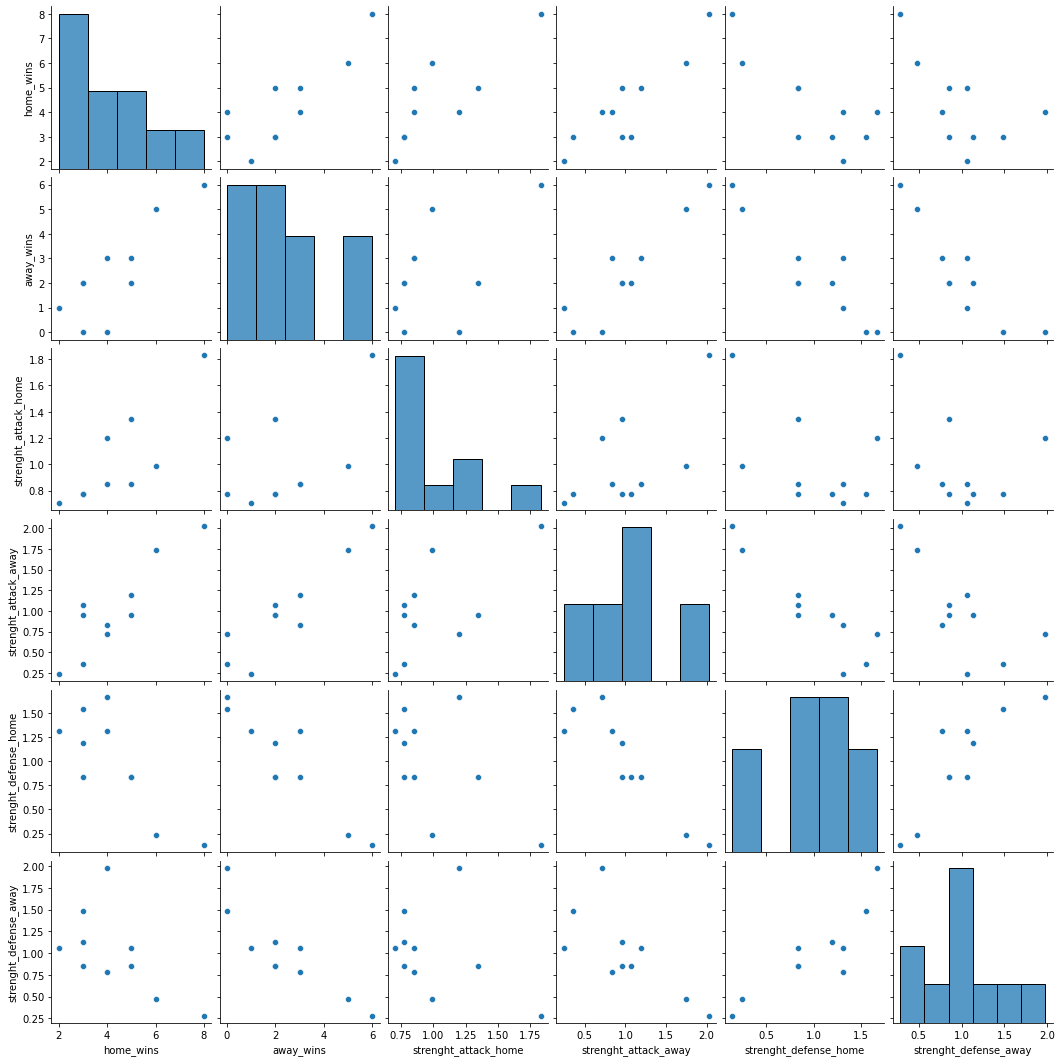

In [41]:
relevantxG = [
    "home_wins",
    "away_wins",
    "strenght_attack_home",
    "strenght_attack_away",
    "strenght_defense_home",
    "strenght_defense_away",
]

df_team_xG = X_EDA.loc[:, relevantxG]

sns.pairplot(df_team_xG)

## Pivoting

## Correlation

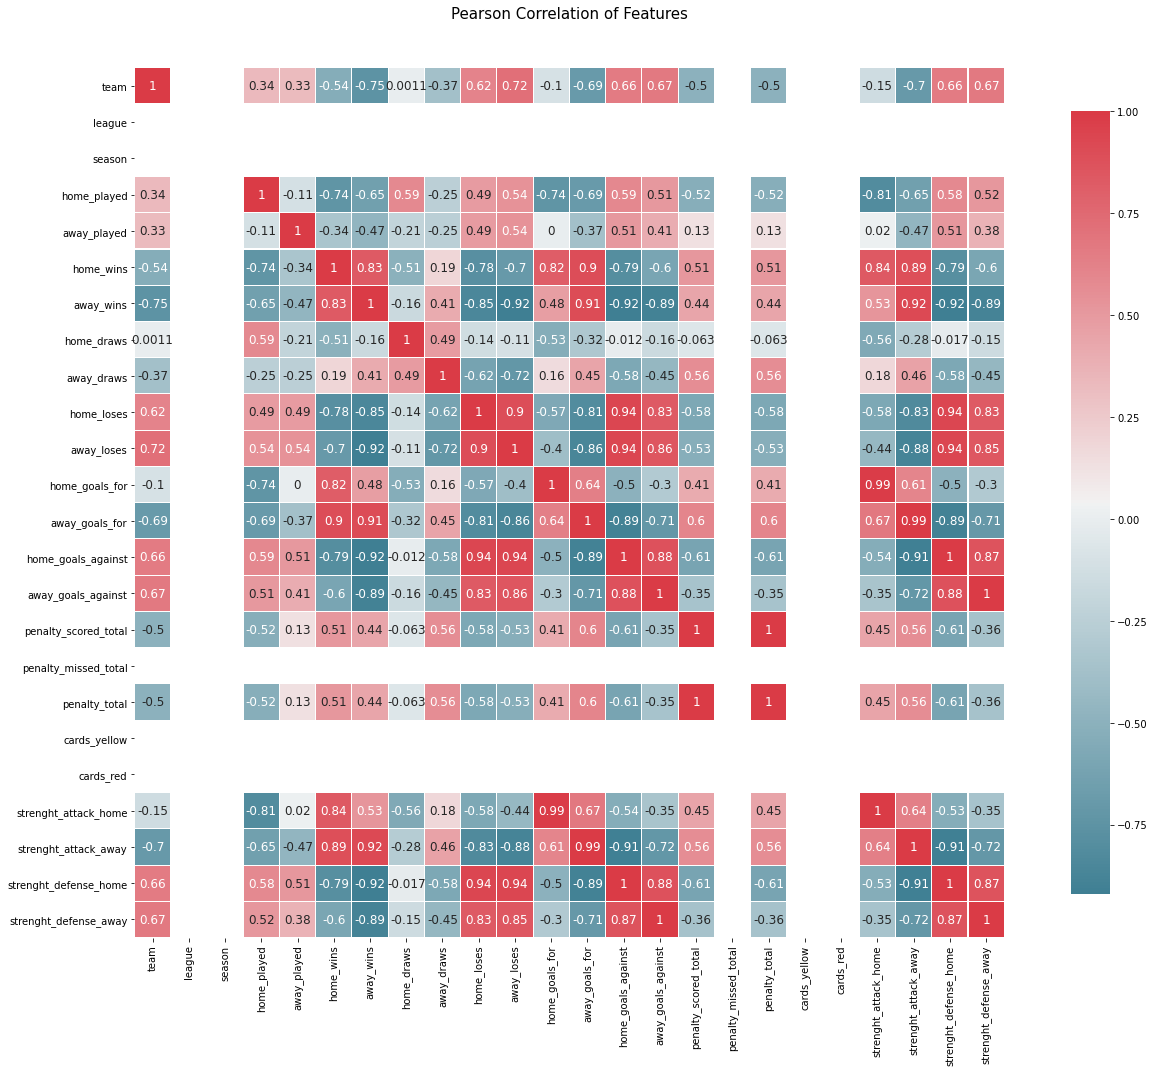

In [43]:
correlation_heatmap(X_EDA, figsize=(24,16))

In [54]:
#Get list of categorical variables
s = (X_EDA.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


## Dimensionality reduction

### PCA
- Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss.

In [58]:
n_components = 3 # reduce to this dimensions
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(X_EDA)
PCA_ds = pd.DataFrame(pca.transform(X_EDA), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-1.429437e-16,2.878377,-5.969395,-2.538494,-0.780421,2.383290,7.444305
col2,2212.0,-9.435892e-18,1.706839,-4.312184,-1.328304,-0.158030,1.242265,6.142645
col3,2212.0,7.260116e-17,1.221956,-3.530763,-0.828709,-0.022538,0.799510,6.615153


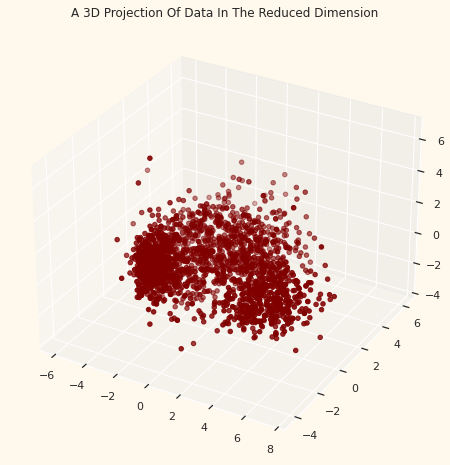

In [59]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

## Insights
- 


<a id="5"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">MODELING</p>

## Setup

In [46]:
avg_num_goals_scored_home = pipelineDataProcessing.cache["feature_engineering"]["avg_num_goals_scored_home"]
avg_num_goals_scored_away = pipelineDataProcessing.cache["feature_engineering"]["avg_num_goals_scored_away"]
avg_num_goals_conc_home = pipelineDataProcessing.cache["feature_engineering"]["avg_num_goals_conc_home"]
avg_num_goals_conc_away = pipelineDataProcessing.cache["feature_engineering"]["avg_num_goals_conc_away"]

In [51]:
def expectedGoals(strenght_attack_team1, strenght_defense_team2, avg_num_goals):
    return strenght_attack_team1 * strenght_defense_team2 * avg_num_goals

def expectedGoalsTeamHomevsTeamAway(df:pd.DataFrame, team_home:str, team_away:str, avg_num_goals_scored_home:int, avg_num_goals_scored_away:int):
    
    xG_team_home = expectedGoals(
        df.loc[team_home, "strenght_attack_home"],
        df.loc[team_away, "strenght_defense_away"],
        avg_num_goals_scored_home
    )

    xG_team_away = expectedGoals(
        df.loc[team_away, "strenght_attack_away"],
        df.loc[team_home, "strenght_defense_home"],
        avg_num_goals_scored_away
    )
    
    return (xG_team_home, xG_team_away)

def addMarginToOdds(odds:list, margin_percentage:float):
    k:float = 1/(1+margin_percentage)
    return [(value*k) for value in odds]

def getImpliedOdds(odds:list, probability_sum:float):
    return [(value*probability_sum) for value in odds]

def sumOddsAsProbability(odds:list):
    p = 0
    for odd in odds:
        p += 1/odd
    return p



In [50]:
# Sanity check
xG_Uruguay, xG_Chile = expectedGoalsTeamHomevsTeamAway(
    df_teams_statistics_clean, "Uruguay", "Chile",
    avg_num_goals_scored_home, avg_num_goals_scored_away
)
# print(xG_Uruguay, xG_Chile)

colsvs = ["datetime", "goals_home", "goals_away", "score_halftime_home", "score_halftime_away", "home_statistics", "away_statistics"]
mask_uruguayvschile = (df_fixtures["team_home_name"] == "Uruguay") & (df_fixtures["team_away_name"] == "Chile")
print(f"Expected goals for Uruguay {xG_Uruguay} vs Chile {xG_Chile}")
print("Real goals in A real fixture Uruguay (home) vs Chile (away)")
df_fixtures[mask_uruguayvschile].loc[0, colsvs]    

Expected goals for Uruguay 1.5068783068783067 vs Chile 0.7413357132232634
Real goals in A real fixture Uruguay (home) vs Chile (away)


datetime                                       2020-10-08T22:45:00+00:00
goals_home                                                             2
goals_away                                                             1
score_halftime_home                                                    1
score_halftime_away                                                    0
home_statistics        [{'type': 'Shots on Goal', 'value': 2}, {'type...
away_statistics        [{'type': 'Shots on Goal', 'value': 3}, {'type...
Name: 0, dtype: object

## Model: Poisson Distribution to get Odds using xG

In [53]:
size = 100000  # sample space

### Sample distribution

<AxesSubplot:>

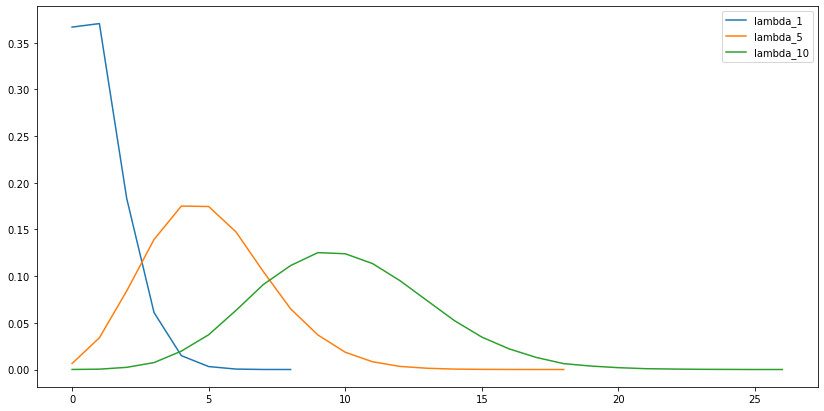

In [54]:
df = pd.DataFrame({
    'lambda_1': np.random.poisson(lam=1, size=size),
    'lambda_5': np.random.poisson(lam=5, size=size),
    'lambda_10': np.random.poisson(lam=10, size=size),
})
poisson_dist = pd.DataFrame({
    'lambda_1': df.lambda_1.value_counts(normalize=True),
    'lambda_5': df.lambda_5.value_counts(normalize=True),
    'lambda_10': df.lambda_10.value_counts(normalize=True),
})

poisson_dist.plot(figsize=(14, 7))

### OddsPoisson

In [84]:
class OddsPoisson:
    
    def __init__(self, max_goals = 9):
        self.max_goals = max_goals
    
    def getPoissonOutcomes(self, home_team:str, xG_home:float, away_team:str, xG_away:float)->pd.DataFrame:
        # Using xG
        df_sim = pd.DataFrame({
            home_team: np.random.poisson(xG_home, size=size),
            away_team: np.random.poisson(xG_away, size=size),
        })

        df_outcomes = pd.DataFrame({
            home_team: df_sim[home_team].value_counts(normalize=True),
            away_team: df_sim[away_team].value_counts(normalize=True),
        })

        df_outcomes = df_outcomes.fillna(0)
        return df_outcomes
    
    def getProbabilitiesTable(self, home_team:str, away_team:str, df_outcomes:pd.DataFrame)->pd.DataFrame:
        
        df_probs = pd.DataFrame(columns=list(range(self.max_goals+1)))
        for i in range(self.max_goals+1):
            row = {}
            for j in range(self.max_goals+1):
                row[j] = df_outcomes.iloc[i][home_team] * df_outcomes.iloc[j][away_team]
            df_probs = df_probs.append(row, ignore_index=True)
        df_probs = df_probs.fillna(0)
        return df_probs
    
    def getOdds(self, home_team:str, xG_home:float, away_team:str, xG_away:float):
        df_outcomes = self.getPoissonOutcomes(home_team, xG_home, away_team, xG_away)
        df_probs = self.getProbabilitiesTable(home_team, away_team, df_outcomes)
        
        # sum all diagonal of probabilities. The diagonal are draws
        sum_diagonal = df_probs.values.diagonal().sum()
        odds_draw = 1/sum_diagonal

        # Option 1: comples sum around below/above diagonal
        sum_probs_win_home = 0
        for i in range(1,self.max_goals+1):
            for j in range(0, i):
                sum_probs_win_home += df_probs.iloc[i,j]
        odds_win_home = 1/sum_probs_win_home

        # Option 2: use the individual and multiply manually where team A has more probability than team B
        sum_probs_win_away = 0
        for i in range(1, self.max_goals+1):
            for j in range(i):
                sum_probs_win_away += df_outcomes.iloc[i][away_team] * df_outcomes.iloc[j][home_team]

        odds_win_away = 1/sum_probs_win_away

        return (odds_draw, odds_win_home, odds_win_away)
        
        
model_poisson = OddsPoisson()
        

### Poisson probabilities: Chile (home) vs Colombia (away)

In [94]:
home_team = "Brazil"
away_team = "Uruguay"
xG_home, xG_away = expectedGoalsTeamHomevsTeamAway(
    df_teams_statistics_clean, home_team, away_team,
    avg_num_goals_scored_home, avg_num_goals_scored_away
)
print(xG_home, xG_away)


3.046130952380952 0.1489290495314592


The table below shows that Brazil has a 14.39 % chance to score 1 goals, 22.23 % chance to score 2 goals and so on.

In [95]:
df_outcomes = model_poisson.getPoissonOutcomes(home_team, xG_home, away_team, xG_away)
df_outcomes

,Brazil,Uruguay
0,0.04712,0.86056
1,0.14389,0.12952
2,0.22233,0.00930
3,0.22361,0.00059
4,0.17027,0.00003
5,0.10465,0.00000
6,0.05195,0.00000
7,0.02338,0.00000
8,0.00879,0.00000
9,0.00274,0.00000


The probabilities in the table above are independent, meaning that we can multiply them and calculate the probabilities of multiple outcomes. The goals in rows are for Brazil and columns for Uruguay. Results 2:1 for Brazil has a 2.87 % chance.

In [97]:
df_probs = model_poisson.getProbabilitiesTable(home_team, away_team, df_outcomes)
df_probs

,0,1,2,3,4,5,6,7,8,9
0,0.040550,0.006103,0.000438,0.000028,1.413600e-06,0.0,0.0,0.0,0.0,0.0
1,0.123826,0.018637,0.001338,0.000085,4.316700e-06,0.0,0.0,0.0,0.0,0.0
2,0.191328,0.028796,0.002068,0.000131,6.669900e-06,0.0,0.0,0.0,0.0,0.0
3,0.192430,0.028962,0.002080,0.000132,6.708300e-06,0.0,0.0,0.0,0.0,0.0
4,0.146528,0.022053,0.001584,0.000100,5.108100e-06,0.0,0.0,0.0,0.0,0.0
5,0.090058,0.013554,0.000973,0.000062,3.139500e-06,0.0,0.0,0.0,0.0,0.0
6,0.044706,0.006729,0.000483,0.000031,1.558500e-06,0.0,0.0,0.0,0.0,0.0
7,0.020120,0.003028,0.000217,0.000014,7.014000e-07,0.0,0.0,0.0,0.0,0.0
8,0.007564,0.001138,0.000082,0.000005,2.637000e-07,0.0,0.0,0.0,0.0,0.0
9,0.002358,0.000355,0.000025,0.000002,8.220000e-08,0.0,0.0,0.0,0.0,0.0


### Odds calculation

In [98]:
odds = model_poisson.getOdds(home_team, xG_home, away_team, xG_away)

print("**Odds**")
print(f"Draw {odds[0]} ({100/odds[0]}) %")
print(f"{home_team} win {odds[1]} ({100/odds[1]}) %")
print(f"{away_team} win {odds[2]} ({100/odds[2]}) %")
print("Total probability", sumOddsAsProbability(odds))
print("Total probability with margin 5%", sumOddsAsProbability(addMarginToOdds(odds,0.05)))



**Odds**
Draw 16.056040797384924 (6.228185470000001) %
Brazil win 1.0772883859948459 (92.82565495000001) %
Uruguay win 120.60404584603604 (0.8291595800000001) %
Total probability 0.9988300000000003
Total probability with margin 5% 1.0487715000000002


### Example for Chile vs Colombia

In [99]:
home_team = "Chile"
away_team = "Colombia"
xG_home, xG_away = expectedGoalsTeamHomevsTeamAway(
    df_teams_statistics_clean, home_team, away_team,
    avg_num_goals_scored_home, avg_num_goals_scored_away
)
print(xG_home, xG_away)
odds = model_poisson.getOdds(home_team, xG_home, away_team, xG_away)

print("**Odds**")
print(f"Draw {odds[0]} ({100/odds[0]}) %")
print(f"{home_team} win {odds[1]} ({100/odds[1]}) %")
print(f"{away_team} win {odds[2]} ({100/odds[2]}) %")
print("Total probability", sumOddsAsProbability(odds))
print("Total probability with margin 5%", sumOddsAsProbability(addMarginToOdds(odds,0.05)))



1.0359788359788358 1.1914323962516735
**Odds**
Draw 3.4768843583495608 (28.76138223) %
Chile win 3.1198155821102316 (32.053176660000005) %
Colombia win 2.5519682098074004 (39.18544110999999) %
Total probability 1.0
Total probability with margin 5% 1.05


## Model: Predict number of goals for home and away given embed strengths

In [107]:
def get_embed_stats(df_teams_statistics:pd.DataFrame, team_name:str):
    """

    Args:
        team_name (str): _description_
    """
    team = df_teams_statistics.loc[team_name, ["strenght_attack_home", "strenght_attack_away", "strenght_defense_home",	"strenght_defense_away"]]
    
    return team.values

print(get_embed_stats(df_teams_statistics_clean, "Ecuador"))

# 

[1.342063492063492 0.9531459170013387 0.8340026773761714
 0.8476190476190475]


In [116]:

columns = [
    "home_strenght_attack_home", 
    "home_strenght_attack_away", 
    "home_strenght_defense_home",
    "home_strenght_defense_away",
    "away_strenght_attack_home", 
    "away_strenght_attack_away", 
    "away_strenght_defense_home",
    "away_strenght_defense_away",
    "home_result", 
    "away_result"
]
df_dataset = pd.DataFrame(columns=columns)

cols_data = {c:[] for c in columns}

for i in range(len(df_fixtures)):
    row_serie = df_fixtures.iloc[i, :]
    
    home_embed = get_embed_stats(df_teams_statistics_clean, row_serie["team_home_name"])
    away_embed = get_embed_stats(df_teams_statistics_clean, row_serie["team_away_name"])
    
    
    cols_data["home_strenght_attack_home"].append(home_embed[0])
    cols_data["home_strenght_attack_away"].append(home_embed[1])
    cols_data["home_strenght_defense_home"].append(home_embed[2])
    cols_data["home_strenght_defense_away"].append(home_embed[3])
    cols_data["away_strenght_attack_home"].append(away_embed[0])
    cols_data["away_strenght_attack_away"].append(away_embed[1])
    cols_data["away_strenght_defense_home"].append(away_embed[2])
    cols_data["away_strenght_defense_away"].append(away_embed[3])
    cols_data["home_result"].append(row_serie["goals_home"])
    cols_data["away_result"].append(row_serie["goals_away"])


df_dataset = df_dataset.from_dict(cols_data)
df_dataset.head()


,home_strenght_attack_home,home_strenght_attack_away,home_strenght_defense_home,home_strenght_defense_away,away_strenght_attack_home,away_strenght_attack_away,away_strenght_defense_home,away_strenght_defense_away,home_result,away_result
0,0.847619,1.191432,0.834003,1.059524,0.776984,0.953146,1.191432,1.130159,2,1
1,0.776984,1.072289,0.834003,0.847619,0.776984,0.357430,1.548862,1.483333,3,0
2,1.827679,2.025435,0.134036,0.282540,1.200794,0.714859,1.668005,1.977778,5,0
3,0.706349,0.238286,1.310576,1.059524,0.847619,0.834003,1.310576,0.776984,2,2
4,0.988889,1.742470,0.238286,0.476786,1.342063,0.953146,0.834003,0.847619,1,0


In [129]:
X = df_dataset.drop(columns=["home_result", "away_result"], axis=0).to_numpy()
y = df_dataset.loc[:, ["home_result", "away_result"]].to_numpy()

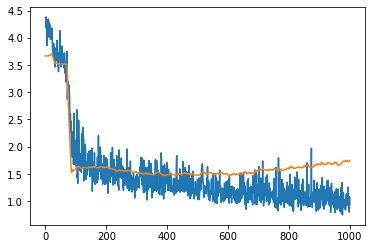

In [141]:
# Explorate the neural network
# input_shape = (len(X_train[0]),)

model = Sequential(
    layers=[
        Dense(8, kernel_initializer='he_normal', activation="relu"),
        Dropout(0.1),
        Dense(2, kernel_initializer='he_normal', activation="relu")
    ]
)
adam = Adam(learning_rate=0.001)

model.compile(loss="mse", optimizer=adam) # , metrics=['accuracy']

EPOCHS = 120

h = model.fit(
    X, 
    y,
    epochs=EPOCHS,
    batch_size=4,
    validation_split=0.2,
    verbose=0
)
history = h.history
plt.plot(history["loss"])
plt.plot(history["val_loss"])


In [144]:
one_test = np.array([[
    0.706349,
    0.238286,
    1.310576,
    1.059524,
    0.847619,
    0.834003,
    1.310576,
    0.776984
]])
print(one_test)

[[0.706349 0.238286 1.310576 1.059524 0.847619 0.834003 1.310576 0.776984]]


In [145]:
model.predict(one_test)

array([[2.1569657, 1.5413201]], dtype=float32)

<a id="6"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">EVALUATION</p>

<a id="7"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">DISCUSSION</p>

## Conclusions
- 

<a id="8"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">DEPLOYMENT AND ENSEMBLES</p>

<a id="9"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">END</p>

[Return to table of contents](#top)